In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from models import vae
from utils.evaluation import Evaluation
from IPython.display import clear_output
import sys
import matplotlib.pyplot as plt
from utils.PDE_process import Protein

In [2]:
########## Define Parameters ##########

In [3]:
LATENT_DIM = 2
LAYERS = 4
EPOCHS = 200
BATCH_SIZE = 256
template_file = '../data/pdbs/toho.pdb'

In [4]:
########## Data Source ##########

In [5]:
# load data
data = np.load('../data/features/toho.npz')
coor_encode = data['coor']  # use every frame from the data
coor_encode.shape

(20000, 5820)

In [6]:
# scale data
scaler = MinMaxScaler()
coor_encode_scaled = scaler.fit_transform(coor_encode)

In [7]:
########## Build VAE ##########

In [8]:
# hidden layers
hidden_layers = [LATENT_DIM]
while len(hidden_layers) <= LAYERS:
    hidden_layers.append(hidden_layers[-1] * 4
                         if hidden_layers[-1] * 4 <= coor_encode_scaled.shape[1]
                         else coor_encode_scaled.shape[1])
hidden_layers = hidden_layers[::-1]
hidden_layers.pop()
hidden_layers

[512, 128, 32, 8]

In [9]:
input_dim = (coor_encode_scaled.shape[1],)

In [10]:
encoder, decoder, model = vae.build_vae(input_dim, hidden_layers, latent_dim=LATENT_DIM)
print(encoder.summary())

2022-05-10 16:20:48.171304: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-10 16:20:49.045956: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15393 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:06:00.0, compute capability: 6.0


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5820)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          2980352     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          65664       dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 32)           4128        dense_1[0][0]                    
______________________________________________________________________________________________

In [11]:
# %%time
# history = model.fit(
#     x=coor_encode_scaled,
#     y=coor_encode_scaled,
#     shuffle=True,
#     epochs=EPOCHS,
#     verbose=0,
#     batch_size=BATCH_SIZE)

In [12]:
# plt.plot(list(range(1,len(history.history['loss'])+1)), [x/1806 for x in history.history['loss']])
# plt.show()

In [13]:
# encoder.save_weights('../results/toho/encoder.h5')
# decoder.save_weights('../results/toho/decoder.h5')

In [14]:
encoder.load_weights('../results/toho/encoder.h5')
decoder.load_weights('../results/toho/decoder.h5')

In [15]:
data_latent = encoder.predict(coor_encode_scaled)[0]
data_latent.shape

2022-05-10 16:21:17.372854: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(20000, 2)

In [16]:
data_latent[:10]

array([[1.241989 , 1.149547 ],
       [1.3499848, 1.3042995],
       [1.233759 , 1.1943915],
       [1.3086935, 1.1644024],
       [1.3258457, 1.2036394],
       [1.3292625, 1.1656814],
       [1.3692654, 1.220214 ],
       [1.4019018, 1.1650206],
       [1.5082031, 1.2816265],
       [1.4522271, 1.3251532]], dtype=float32)

In [17]:
coor_decode_scaled = decoder(data_latent).numpy()
coor_decode_scaled.shape

(20000, 5820)

In [18]:
coor_decode = scaler.inverse_transform(coor_decode_scaled)
coor_decode.shape

(20000, 5820)

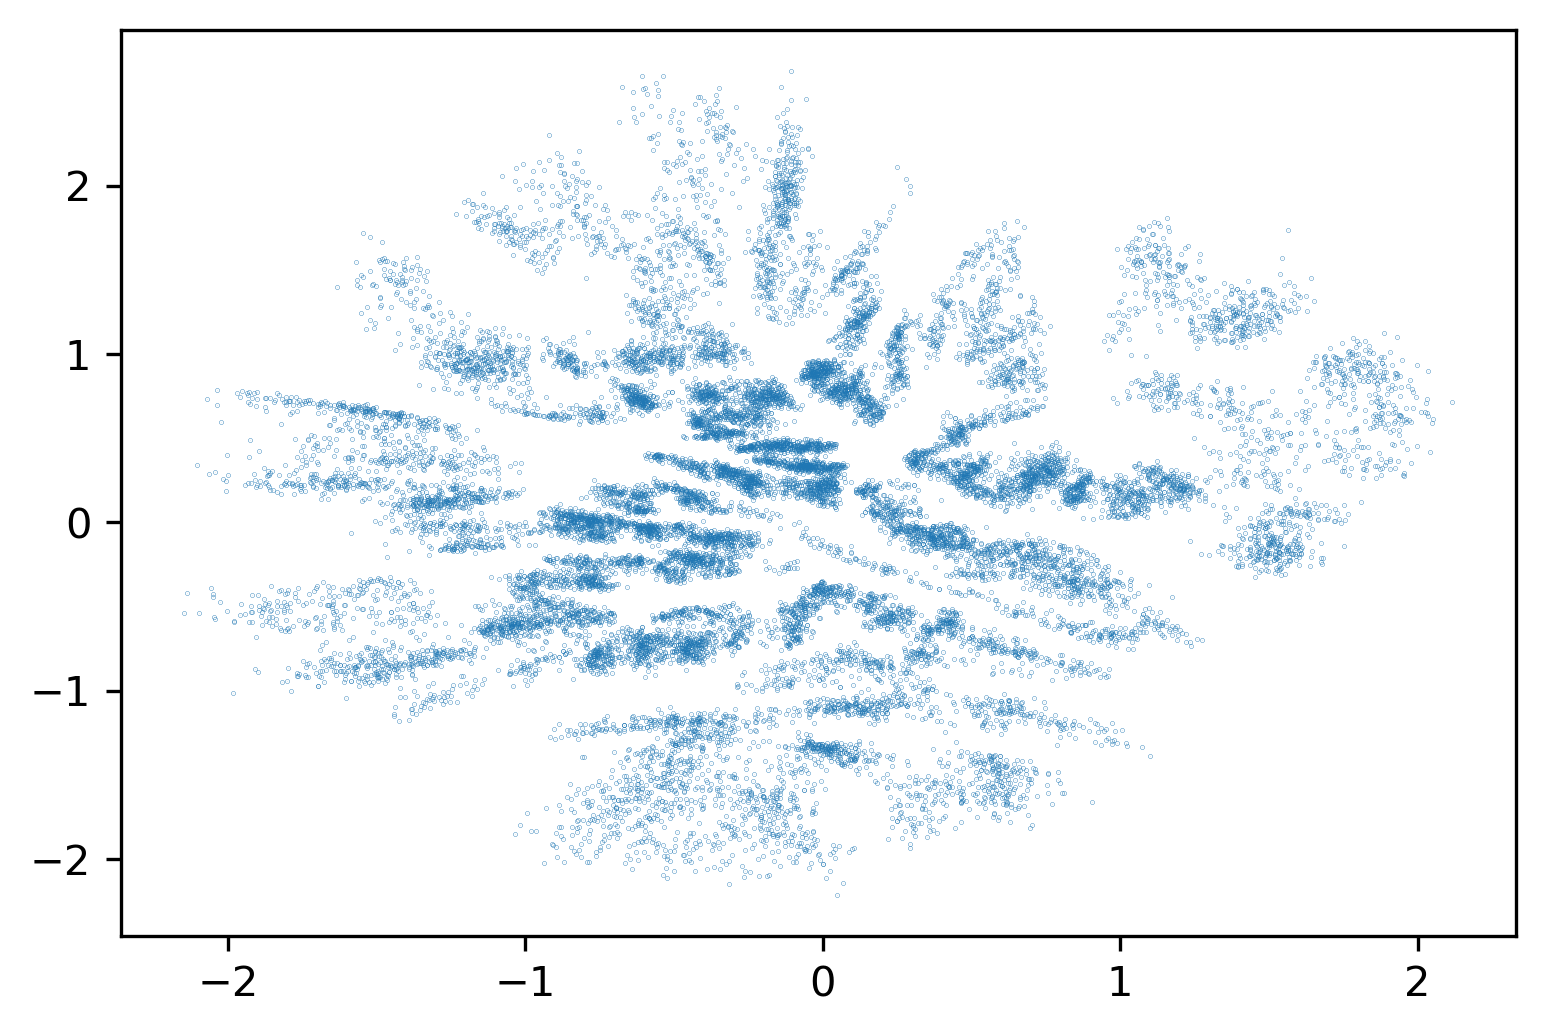

In [19]:
plt.figure(dpi=300)
plt.scatter(data_latent[:,0], data_latent[:,1], s=0.01)
# plt.savefig('toho_latent.png')

In [20]:
# np.savez('toho_data_latent.npz', data_latent=data_latent)

In [21]:
#### new points md

In [22]:
new_points = np.load("../data/features/toho_new.npz")

In [23]:
AP = new_points['AP']  # (0.2, 0.4)
AV = new_points['AV']
BP = new_points['BP']  # (-0.5, -1)
BV = new_points['BV']
CP = new_points['CP']  # (-1, 0.5)
CV = new_points['CV']
DP = new_points['DP']  # (-2, -2)
DV = new_points['DV']
EP = new_points['EP']  # (-2, 2)
EV = new_points['EV']
FP = new_points['FP']  # (2, -2)
FV = new_points['FV']
GP = new_points['GP']  # (2, 2)
GV = new_points['GV']

In [24]:
AP_latent = encoder.predict(scaler.transform(AP))[0]
AV_latent = encoder.predict(scaler.transform(AV))[0]
BP_latent = encoder.predict(scaler.transform(BP))[0]
BV_latent = encoder.predict(scaler.transform(BV))[0]
CP_latent = encoder.predict(scaler.transform(CP))[0]
CV_latent = encoder.predict(scaler.transform(CV))[0]
DP_latent = encoder.predict(scaler.transform(DP))[0]
DV_latent = encoder.predict(scaler.transform(DV))[0]
EP_latent = encoder.predict(scaler.transform(EP))[0]
EV_latent = encoder.predict(scaler.transform(EV))[0]
FP_latent = encoder.predict(scaler.transform(FP))[0]
FV_latent = encoder.predict(scaler.transform(FV))[0]
GP_latent = encoder.predict(scaler.transform(GP))[0]
GV_latent = encoder.predict(scaler.transform(GV))[0]

In [27]:
ta = encoder.predict(scaler.transform(scaler.inverse_transform(decoder(np.array([0.2,0.4]).reshape(1,-1)))))[0]
tb = encoder.predict(scaler.transform(scaler.inverse_transform(decoder(np.array([-0.5,-1]).reshape(1,-1)))))[0]
tc = encoder.predict(scaler.transform(scaler.inverse_transform(decoder(np.array([-1,0.5]).reshape(1,-1)))))[0]
td = encoder.predict(scaler.transform(scaler.inverse_transform(decoder(np.array([-2,-2]).reshape(1,-1)))))[0]
te = encoder.predict(scaler.transform(scaler.inverse_transform(decoder(np.array([-2,2]).reshape(1,-1)))))[0]
tf = encoder.predict(scaler.transform(scaler.inverse_transform(decoder(np.array([2,-2]).reshape(1,-1)))))[0]
tg = encoder.predict(scaler.transform(scaler.inverse_transform(decoder(np.array([2,2]).reshape(1,-1)))))[0]

In [28]:
smaller_points_npt = np.load("../data/features/out_npt_2_2_5_20.npz")['coor']
smaller_points_nvt = np.load("../data/features/out_nvt_2_2_5_20.npz")['coor']

In [29]:
smaller_points_npt_latent = encoder.predict(scaler.transform(smaller_points_npt))[0]
smaller_points_nvt_latent = encoder.predict(scaler.transform(smaller_points_nvt))[0]

In [31]:
np.savez(
    'toho_generate.npz',
    data_latent = data_latent,
    AP_latent = AP_latent,
    AV_latent = AV_latent,
    BP_latent = BP_latent,
    BV_latent = BV_latent,
    CP_latent = CP_latent,
    CV_latent = CV_latent,
    DP_latent = DP_latent,
    DV_latent = DV_latent,
    EP_latent = EP_latent,
    EV_latent = EV_latent,
    FP_latent = FP_latent,
    FV_latent = FV_latent,
    GP_latent = GP_latent,
    GV_latent = GV_latent,
    ta = ta,
    tb = tb,
    tc = tc,
    td = td,
    te = te,
    tf = tf,
    tg = tg,
    smaller_points_npt_latent = smaller_points_npt_latent,
    smaller_points_nvt_latent = smaller_points_nvt_latent
)

In [32]:
template_file = '../data/pdbs/toho.pdb'
protein = Protein()
protein.extract_template(template_file)

In [37]:
long = './toho_0.2_0.4_long.pdb'
protein.load_coor(AP[0] * 10)
protein.write_file(long)

In [38]:
long = './toho_-0.5_-1_long.pdb'
protein.load_coor(BP[0] * 10)
protein.write_file(long)

In [39]:
long = './toho_-1_0.5_long.pdb'
protein.load_coor(CP[0] * 10)
protein.write_file(long)

In [40]:
long = './toho_-2_-2_long.pdb'
protein.load_coor(DP[0] * 10)
protein.write_file(long)

In [41]:
long = './toho_-2_2_long.pdb'
protein.load_coor(EP[0] * 10)
protein.write_file(long)

In [42]:
long = './toho_2_-2_long.pdb'
protein.load_coor(FP[0] * 10)
protein.write_file(long)

In [36]:
long = './toho_2_2_long.pdb'
protein.load_coor(GP[0] * 10)
protein.write_file(long)

In [35]:
short = './toho_2_2_short.pdb'
protein.load_coor(smaller_points_npt[0] * 10)
protein.write_file(short)